In [3]:
import pandas as pd
import nltk
nltk.download("punkt")
import numpy as np
import string
import json
import matplotlib.pyplot as plt
import csv
import os
from sklearn.utils import shuffle

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidanc

# Data sources: 

1) Random twitter tweets called "random tweets" and 'rand_tweets'in the following code - from: https://data.world/data-society/twitter-user-data 

2) Russian Internet Research Agency (rira) Tweets called "tweets.csv" and 'rira_tweets' in the following code - from: https://www.kaggle.com/vikasg/russian-troll-tweets?select=tweets.csv

3) Random Corpus tweets from the nltk database called "twit_samples_corpus" in the following code

4) Data for US Congress party affilication was pulled from https://www.kaggle.com/fivethirtyeight/fivethirtyeight-congress-age-dataset

# Injesting the data

In [4]:
rira_data = pd.read_csv("./tweets.csv")

In [5]:
rand_data = pd.read_csv("./Random_Tweets.csv")

In [6]:
from nltk.corpus import twitter_samples

In [7]:
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [8]:
twit_samples_corpus = ([(t,'pos')for t in twitter_samples.strings("positive_tweets.json")] + 
             [(t,'neg') for t in twitter_samples.strings("negative_tweets.json")])

In [9]:
twit_samples_corpus[-1]

('@eawoman As a Hull supporter I am expecting a misserable few weeks :-(',
 'neg')

In [10]:
twit_sample_corpus_unlabeled = twitter_samples.strings("positive_tweets.json") + twitter_samples.strings("negative_tweets.json")+twitter_samples.strings("tweets.20150430-223406.json")

In [11]:
twit_sample_corpus_unlabeled

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 '@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) https://t.co/smyYriipxI",
 '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan :D bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing 

In [12]:
rira_data.shape

(203482, 16)

In [13]:
rand_data.shape

(20050, 26)

In [14]:
rira_data.head(1)

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,1.868981e+09,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,NaN,NaN,NaN,#IslamKills Are you trying to say that there w...,7.123460e+17,NaN,"[""IslamKills""]",[],POSTED,[],NaN,NaN


In [15]:
rira_IDs = pd.DataFrame(rira_data.user_key.unique(),columns = ["TwitterHandle"])

In [16]:
rira_IDs 
    

,TwitterHandle
0,ryanmaxwell_1
1,detroitdailynew
2,cookncooks
3,queenofthewo
4,mrclydepratt
...,...
449,jon_underwood_
450,milwaukeevoice
451,horrorki
452,mrservelat


# Cleaning the data

In [17]:
rira_data = rira_data[rira_data.text.isnull()==False] # drops Null text

In [18]:
rand_data = rand_data[rand_data.text.isnull() == False]

### Random tweets cleaning 

In [19]:
rand_tweets = rand_data.text

In [20]:
rand_data.text.isnull().any()

False

In [21]:
rand_tweets = pd.DataFrame(rand_tweets)

In [22]:
rand_tweets['rira'] = 0

### RIRA tweet cleaning

In [23]:
rira_tweets = rira_data.text

In [24]:
rira_tweets.head()

0    #IslamKills Are you trying to say that there w...
1    Clinton: Trump should’ve apologized more, atta...
2    RT @ltapoll: Who was/is the best president of ...
3    RT @jww372: I don't have to guess your religio...
4    RT @Shareblue: Pence and his lawyers decided w...
Name: text, dtype: object

In [25]:
rira_tweets = pd.DataFrame(rira_tweets)

In [26]:
rira_tweets['rira']=1

In [27]:
rira_tweets.head()

,text,rira
0,#IslamKills Are you trying to say that there w...,1
1,"Clinton: Trump should’ve apologized more, atta...",1
2,RT @ltapoll: Who was/is the best president of ...,1
3,RT @jww372: I don't have to guess your religio...,1
4,RT @Shareblue: Pence and his lawyers decided w...,1


In [28]:
rira_text = rira_tweets.text

### Corpus Tweets Cleaning

In [29]:
twit_sample_corpus_unlabeled = pd.DataFrame(twit_sample_corpus_unlabeled )

In [30]:
twit_sample_corpus_unlabeled.head()

,0
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,@Lamb2ja Hey James! How odd :/ Please call our...
2,@DespiteOfficial we had a listen last night :)...
3,@97sides CONGRATS :)
4,yeaaaah yippppy!!! my accnt verified rqst has...


### Create tweet files for RIRA handles

In [31]:
rira_IDs = pd.DataFrame(rira_data.user_key.unique(),columns = ["TwitterHandle"])

In [32]:
### creates RIRA twitter files by handle 
#### DO NOT NEED TO RUN AGAIN
for handle in rira_IDs['TwitterHandle']:
    tweets = rira_data[rira_data.user_key==handle]
    tweets=tweets.reset_index()
    del tweets['index']
    path = './RIRA_tweets/'
    ending = ".csv"
    tweets.to_csv(path_or_buf= path+handle+ending)

In [33]:
tweets=tweets.reset_index()
del tweets['index']

In [34]:
rira_data[rira_data.favorite_count==rira_data.favorite_count.max()]

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
101054,4.859142e+09,trayneshacole,1.479414e+12,2016-11-17 20:27:21,20494.0,False,26655.0,go all the way off https://t.co/QtScy6u8I7,7.993482e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",[],[],POSTED,[],NaN,NaN


### top ten twitter accounts

source of 10 ten wikipedia
data pulled using tweetscraper.ipynb

In [35]:
top_ten_accounts = !ls ./TopTenAccounts

In [36]:
for account in top_ten_accounts:
    print(account)


@ArianaGrande_tweets.csv
@BarackObama_tweets.csv
@Cristiano_tweets.csv
@TheEllenShow_tweets.csv
@justinbieber_tweets.csv
@katyperry_tweets.csv
@ladygaga_tweets.csv
@realDonaldTrump_tweets.csv
@rihanna_tweets.csv
@taylorswift13_tweets.csv


In [37]:
top_ten_tweets = pd.DataFrame({'handle':[],'id':[],'created_at':[],'text':[],'likes':[],'in reply to':[],'retweeted':[]})

In [38]:
top_ten_tweets

,handle,id,created_at,text,likes,in reply to,retweeted


In [39]:
dfs=[]
for account in top_ten_accounts:
    data = pd.read_csv("./TopTenAccounts/"+account)
    handle = account.strip('@').split("_tweets.csv")[0]
    data['handle'] = handle
    dfs.append(data)
    print(account, handle)
    top_ten_tweets = pd.concat(dfs)

@ArianaGrande_tweets.csv ArianaGrande
@BarackObama_tweets.csv BarackObama
@Cristiano_tweets.csv Cristiano
@TheEllenShow_tweets.csv TheEllenShow
@justinbieber_tweets.csv justinbieber
@katyperry_tweets.csv katyperry
@ladygaga_tweets.csv ladygaga
@realDonaldTrump_tweets.csv realDonaldTrump
@rihanna_tweets.csv rihanna
@taylorswift13_tweets.csv taylorswift13


In [40]:
top_ten_tweets.handle.unique()

array(['ArianaGrande', 'BarackObama', 'Cristiano', 'TheEllenShow',
       'justinbieber', 'katyperry', 'ladygaga', 'realDonaldTrump',
       'rihanna', 'taylorswift13'], dtype=object)

In [41]:
top_ten_tweets_random = shuffle(top_ten_tweets)

In [42]:
top_ten_tweets_random.head()


,id,created_at,text,likes,in reply to,retweeted,handle
1594,1191168642655735809,2019-11-04 01:41:49,@youthevans @ThePopHub 🌨,5887,ringsevens,False,ArianaGrande
874,747124730126282752,2016-06-26 17:49:51,Marriage equality is one year old. But we stil...,49528,NaN,False,BarackObama
1722,708171864435138561,2016-03-11 06:05:04,"RT @CalvinKlein: Music + fashion, together: Ca...",0,NaN,False,justinbieber
1453,791839515677564928,2016-10-28 03:10:26,"We're late, we're late! But we're driving up n...",11600,NaN,False,ladygaga
3047,38260053647560704,2011-02-17 15:34:42,After filming is now time for a photo shooting...,97,NaN,False,Cristiano


In [43]:
top_tweets = pd.DataFrame(top_ten_tweets_random.text)

In [44]:
top_tweets['rira']=0

In [45]:
top_tweets = top_tweets.reset_index()
del top_tweets['index']

In [46]:
top_tweets.head()

,text,rira
0,@youthevans @ThePopHub 🌨,0
1,Marriage equality is one year old. But we stil...,0
2,"RT @CalvinKlein: Music + fashion, together: Ca...",0
3,"We're late, we're late! But we're driving up n...",0
4,After filming is now time for a photo shooting...,0


In [47]:
i=0
not_str = []
while i<26296:
    if type(top_tweets.text[i])!=str:
        not_str.append(i)
    i+=1


In [48]:
top_tweets.dtypes

text    object
rira     int64
dtype: object

### Tokenize the sets

In [49]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stevenhansen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
stopwords = nltk.corpus.stopwords.words("english")

In [51]:
def build_a_bag_of_words_features(words):
    return {
        word: True for word in words \
        if not word in stopwords}

In [52]:
def token_bag_words(data,label):
    i=0 
    length,col = data.shape
    tokenized_tweets = []
    while i<length:
        tokenized_tweets.append(build_a_bag_of_words_features(nltk.word_tokenize(data.iloc[i,0])))
        i+=1
    #return tokenized_tweets
    j=0
    clean_tweets=list(np.arange(len(tokenized_tweets)))
    while j<len(tokenized_tweets):
        clean_tweets[j]=[tokenized_tweets[j],label]
        j+=1
    clean_tweets = tuple(clean_tweets)
    return clean_tweets
                                

In [53]:
rira_bag_of_words = token_bag_words(rira_tweets,'rira')

In [54]:
rand_bag_of_words = token_bag_words(rand_tweets,'rand')

In [55]:
top_bag_of_words = token_bag_words(top_tweets,'top_ten')

In [56]:
top_bag_of_words[0]

[{'@': True, 'youthevans': True, 'ThePopHub': True, '🌨': True}, 'top_ten']

In [57]:
corpus_bag_of_words = token_bag_words(twit_sample_corpus_unlabeled,'corpus')

In [58]:
def token_bag_words_notlabeled(data):
    i=0 
    length,col = data.shape
    tokenized_tweets = []
    while i<length:
        tokenized_tweets.append(build_a_bag_of_words_features(nltk.word_tokenize(data.iloc[i,0])))
        i+=1

# Train Data

In [59]:
from nltk.classify import NaiveBayesClassifier

In [60]:
split = 1000

In [61]:
rira_bag_of_words

([{'#': True,
   'IslamKills': True,
   'Are': True,
   'trying': True,
   'say': True,
   'terrorist': True,
   'attacks': True,
   'Europe': True,
   'refugees': True,
   'let': True,
   '?': True},
  'rira'],
 [{'Clinton': True,
   ':': True,
   'Trump': True,
   '’': True,
   'apologized': True,
   ',': True,
   'attacked': True,
   'less': True,
   'https': True,
   '//t.co/eJampkoHFZ': True},
  'rira'],
 [{'RT': True,
   '@': True,
   'ltapoll': True,
   ':': True,
   'Who': True,
   'was/is': True,
   'best': True,
   'president': True,
   'past': True,
   '25': True,
   'years': True,
   '?': True,
   '(': True,
   'Vote': True,
   '&': True,
   'amp': True,
   ';': True,
   'Retweet': True,
   ')': True},
  'rira'],
 [{'RT': True,
   '@': True,
   'jww372': True,
   ':': True,
   'I': True,
   "n't": True,
   'guess': True,
   'religion': True,
   '!': True,
   '#': True,
   'ChristmasAftermath': True},
  'rira'],
 [{'RT': True,
   '@': True,
   'Shareblue': True,
   ':': True

### RIRA Classifer trained on Rand set

In [128]:
rira_bot_classifier = NaiveBayesClassifier.train(rira_bag_of_words[:split]+rand_bag_of_words[:split])

In [129]:
nltk.classify.util.accuracy(rira_bot_classifier, rira_bag_of_words[split:]+rand_bag_of_words[split:])*100

92.85362803653092

In [130]:
rand_MIF = rira_bot_classifier.show_most_informative_features()

Most Informative Features
                   Trump = True             rira : rand   =     81.0 : 1.0
                 Clinton = True             rira : rand   =     20.6 : 1.0
                 Hillary = True             rira : rand   =     15.8 : 1.0
                      UK = True             rand : rira   =     15.7 : 1.0
                   Group = True             rand : rira   =     15.0 : 1.0
                 largest = True             rand : rira   =     13.7 : 1.0
                greatest = True             rand : rira   =     11.0 : 1.0
                    year = True             rand : rira   =      8.3 : 1.0
                 country = True             rira : rand   =      8.3 : 1.0
                  Street = True             rand : rira   =      7.8 : 1.0


### Classifer RIRA trained on Corpus Set

In [133]:

rira_bot_corpus_classifier = NaiveBayesClassifier.train(rira_bag_of_words[:split]+corpus_bag_of_words[:split])


In [134]:
nltk.classify.util.accuracy(rira_bot_corpus_classifier, rira_bag_of_words[split:]+corpus_bag_of_words[split:])*100

88.8106419656011

In [135]:
rira_bot_corpus_classifier.show_most_informative_features()

Most Informative Features
                   Obama = True             rira : corpus =     37.0 : 1.0
                       ) = True           corpus : rira   =     32.1 : 1.0
                      Hi = True           corpus : rira   =     26.3 : 1.0
                  follow = True           corpus : rira   =     21.3 : 1.0
                    hope = True           corpus : rira   =     14.3 : 1.0
                       u = True           corpus : rira   =     14.3 : 1.0
                midnight = True             rira : corpus =     12.3 : 1.0
                    week = True           corpus : rira   =     11.8 : 1.0
                    good = True           corpus : rira   =     11.8 : 1.0
                      He = True             rira : corpus =     11.7 : 1.0


### RIRA Classifier trained on Top Ten Accounts

In [136]:

rira_bot_top10_classifier = NaiveBayesClassifier.train(rira_bag_of_words[:split]+top_bag_of_words[:split])

In [137]:
nltk.classify.util.accuracy(rira_bot_corpus_classifier, rira_bag_of_words[split:]+top_bag_of_words[split:])*100

86.42763998472056

In [138]:
rira_bot_top10_classifier.show_most_informative_features()

Most Informative Features
                   Trump = True             rira : top_te =     48.6 : 1.0
         realDonaldTrump = True             rira : top_te =     13.7 : 1.0
                politics = True             rira : top_te =     13.0 : 1.0
                    said = True             rira : top_te =      9.7 : 1.0
                       u = True           top_te : rira   =      9.2 : 1.0
                tomorrow = True           top_te : rira   =      9.0 : 1.0
                   Watch = True           top_te : rira   =      9.0 : 1.0
                   album = True           top_te : rira   =      8.3 : 1.0
                      No = True             rira : top_te =      7.7 : 1.0
                election = True             rira : top_te =      7.7 : 1.0


# Testing models

## Questions
Does it just classify highly politicized tweets as rira?

At what point is it overfitting?

Would taking out stop words and punctuation help/hurt?

Can the Neive Bayes classifer differientiate between RIRA tweets and congress tweets?

### tweet tester

make a tweet and test it

In [341]:
def tweet_tester(tweet):
    tokenized_tweet = build_a_bag_of_words_features(nltk.word_tokenize(tweet))
    rand_set_classification = rira_bot_classifier.classify(tokenized_tweet)
    corpus_set_classification = rira_bot_corpus_classifier.classify(tokenized_tweet)
    top10_set_classification = rira_bot_top10_classifier.classify(tokenized_tweet)
    p = "Rand set =  "+rand_set_classification+"\ncorpus set = "+corpus_set_classification+"\ntop10 set = "+top10_set_classification 
    print(p)
    rand = rand_set_classification
    corpus = corpus_set_classification
    top10 = top10_set_classification
    return rand, corpus,top10


In [343]:
rand,corpus,top10 = tweet_tester("make america great again")

Rand set =  rira
corpus set = corpus
top10 set = rira


In [344]:
rand

'rira'

In [345]:
tweet_tester("MAKE AMERICA GREAT AGAIN")

Rand set =  rira
corpus set = rira
top10 set = rira


('rira', 'rira', 'rira')

In [141]:
tweet_tester("Obama is the best")

Rand set =  rira
corpus set = rira
top10 set = top_ten


In [142]:
tweet_tester("trump is terrible")

Rand set =  rira
corpus set = rira
top10 set = rira


In [143]:
tweet_tester("Clinton is a way better choice then trump")

Rand set =  rira
corpus set = rira
top10 set = rira


In [495]:
tweet_tester("This season of the Office was terrible")

Rand set =  rand
corpus set = corpus
top10 set = top_ten


('rand', 'corpus', 'top_ten')

In [157]:
def is_user_rira(tweets):
    i=0
    classified=np.arange(len(tweets))
    while i < len(tweets):
        if rira_bot_classifier.classify(build_a_bag_of_words_features(nltk.word_tokenize(tweets[i])))=="rira":
            classified[i] = 1
        else:
            classified[i]=0
        i+=1
    return (sum(classified)/len(classified))

In [158]:
def is_user_rira_corpus(tweets):
    i=0
    classified=np.arange(len(tweets))
    while i < len(tweets):
        if rira_bot_corpus_classifier.classify(build_a_bag_of_words_features(nltk.word_tokenize(tweets[i])))=="rira":
            classified[i] = 1
        else:
            classified[i]=0
        i+=1
    return (sum(classified)/len(classified))

In [159]:
def is_user_rira_top10(tweets):
    i=0
    classified=np.arange(len(tweets))
    while i < len(tweets):
        if rira_bot_top10_classifier.classify(build_a_bag_of_words_features(nltk.word_tokenize(tweets[i])))=="rira":
            classified[i] = 1
        else:
            classified[i]=0
        i+=1
    return (sum(classified)/len(classified))

## Perparing the sets
Analysis tweets from congressmembers.  List complied using the tweetscraper.ipynb

In [146]:
import os
import pandas as pd

#### Congress Tweets

In [250]:
congress_twitter_handles = pd.read_csv("./116Congress.csv")
congress_twitter_handles['PercentTweetLikeRIRA']=0
congress_twitter_handles['PercentTweetLikeRIRA_corpus']=0
congress_twitter_handles['PercentTweetLikeRIRA_top10']=0

In [251]:
del_indexes = ["ODU-WSDL","TweetCongress","Github","REMARK"]
for ind in del_indexes:
    del congress_twitter_handles[ind]
congress_twitter_handles.head()

,Wikipedia Names,Position,Joined Congress,CSPAN,PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10
0,Doug Jones,Sen,3-Jan-18,sendougjones,0,0,0
1,Richard Shelby,Sen,3-Jan-87,SenShelby,0,0,0
2,Dan Sullivan,Sen,3-Jan-15,SenDanSullivan,0,0,0
3,Lisa Murkowski,Sen,20-Dec-02,LisaMurkowski,0,0,0
4,Kyrsten Sinema,Sen,3-Jan-19,SenatorSinema,0,0,0


In [252]:
congress_twitter_handles=congress_twitter_handles.rename(columns={congress_twitter_handles.columns[0]:"Name","CSPAN":"TwitterHandle"})

In [317]:
congress_twitter_handles.isnull().sum()

Name                           0
Position                       0
Joined Congress                0
TwitterHandle                  4
PercentTweetLikeRIRA           0
PercentTweetLikeRIRA_corpus    0
PercentTweetLikeRIRA_top10     0
FilePath                       0
dtype: int64

In [319]:
congress_twitter_handles=congress_twitter_handles.dropna()

In [320]:
congress_twitter_handles["FilePath"]=0

/Users/stevenhansen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [352]:
i=0
while i<538:
    fp = "./Congress_tweets/@"
    suffix = "_tweets.csv"
    congress_twitter_handles.iloc[i,7]=fp+congress_twitter_handles.iloc[i,3]+suffix
    i+=1
   
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


IndexError: single positional indexer is out-of-bounds

In [322]:
congress_twitter_handles.iloc[186,3]

'RepConorLamb'

In [366]:
congress_twitter_handles.tail()

,Name,Position,Joined Congress,TwitterHandle,PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10,FilePath
533,Will Hurd,Rep,3-Jan-15,hurdonthehill,0,0,0,./Congress_tweets/@hurdonthehill_tweets.csv
534,William Timmons,Rep,3-Jan-19,RepTimmons,0,0,0,./Congress_tweets/@RepTimmons_tweets.csv
535,Xochitl Torres Small,Rep,3-Jan-19,RepTorresSmall,0,0,0,./Congress_tweets/@RepTorresSmall_tweets.csv
536,Yvette Clarke,Rep,3-Jan-13,RepYvetteClarke,0,0,0,./Congress_tweets/@RepYvetteClarke_tweets.csv
537,Zoe Lofgren,Rep,3-Jan-95,RepZoeLofgren,0,0,0,./Congress_tweets/@RepZoeLofgren_tweets.csv


#### Top Tweeters

In [258]:
top_tweeters  = top_ten_tweets.handle.unique()

In [260]:
top_tweeters_handles = {"Name":top_tweeters}

In [264]:
top_tweeters_handles=pd.DataFrame(top_tweeters_handles)
top_tweeters_handles["TwitterHandle"]= top_tweeters

In [272]:
top_tweeters_handles["PercentTweetLikeRIRA"]=0
top_tweeters_handles["PercentTweetLikeRIRA_corpus"]=0
top_tweeters_handles["PercentTweetLikeRIRA_top10"]=0
del top_tweeters_handles["PrecentTweetLikeRIRA_corpus"]

In [284]:
top_tweeters_handles["Position"] = "Top Twitter Account"

In [324]:
top_tweeters_handles["FilePath"] = 0

In [333]:
i=0
while i<10:
    fp = "./TopTenAccounts/@"
    suffix = "_tweets.csv"
    top_tweeters_handles.iloc[i,6]=fp+top_tweeters_handles.iloc[i,1]+suffix
    i+=1

In [400]:
top_tweeters_handles

,Name,TwitterHandle,PercentTweetLikeRIRA,PercentTweetLikeRIRA_top10,PercentTweetLikeRIRA_corpus,Position,FilePath
0,ArianaGrande,ArianaGrande,0.542981,0.126469,0.606370,Top Twitter Account,./TopTenAccounts/@ArianaGrande_tweets.csv
1,BarackObama,BarackObama,0.858816,0.131628,0.918619,Top Twitter Account,./TopTenAccounts/@BarackObama_tweets.csv
2,Cristiano,Cristiano,0.649416,0.076049,0.515305,Top Twitter Account,./TopTenAccounts/@Cristiano_tweets.csv
3,TheEllenShow,TheEllenShow,0.493362,0.116703,0.780179,Top Twitter Account,./TopTenAccounts/@TheEllenShow_tweets.csv
4,justinbieber,justinbieber,0.708849,0.181415,0.732001,Top Twitter Account,./TopTenAccounts/@justinbieber_tweets.csv
5,katyperry,katyperry,0.579442,0.165465,0.800376,Top Twitter Account,./TopTenAccounts/@katyperry_tweets.csv
6,ladygaga,ladygaga,0.645356,0.212468,0.748728,Top Twitter Account,./TopTenAccounts/@ladygaga_tweets.csv
7,realDonaldTrump,realDonaldTrump,0.845000,0.665000,0.925000,Top Twitter Account,./TopTenAccounts/@realDonaldTrump_tweets.csv
8,rihanna,rihanna,0.793275,0.145081,0.494707,Top Twitter Account,./TopTenAccounts/@rihanna_tweets.csv
9,taylorswift13,taylorswift13,0.664706,0.211765,0.850980,Top Twitter Account,./TopTenAccounts/@taylorswift13_tweets.csv


#### RIRA Tweeters

In [281]:
rira_IDs["Name"] = "RIRA"

In [282]:
rira_IDs["PercentTweetLikeRIRA"]=0
rira_IDs["PercentTweetLikeRIRA_top10"]=0
rira_IDs["PercentTweetLikeRIRA_corpus"]=0

In [286]:
rira_IDs["Position"] = "RIRA Account"

In [336]:
rira_IDs["FilePath"] = 0

In [339]:
i=0
while i < 454:
    fp = "./RIRA_tweets/"
    suffix = ".csv"
    rira_IDs.iloc[i,6] = fp+rira_IDs.iloc[i,0]+suffix
    i+=1
    

In [399]:
rira_IDs

,TwitterHandle,Name,PercentTweetLikeRIRA,PercentTweetLikeRIRA_top10,PercentTweetLikeRIRA_corpus,Position,FilePath
0,ryanmaxwell_1,RIRA,0.875360,0.830522,0.921432,RIRA Account,./RIRA_tweets/ryanmaxwell_1.csv
1,detroitdailynew,RIRA,0.970930,0.959302,1.000000,RIRA Account,./RIRA_tweets/detroitdailynew.csv
2,cookncooks,RIRA,0.988228,0.943366,0.994909,RIRA Account,./RIRA_tweets/cookncooks.csv
3,queenofthewo,RIRA,0.927376,0.906961,0.976573,RIRA Account,./RIRA_tweets/queenofthewo.csv
4,mrclydepratt,RIRA,0.995403,0.884769,0.994484,RIRA Account,./RIRA_tweets/mrclydepratt.csv
...,...,...,...,...,...,...,...
449,jon_underwood_,RIRA,1.000000,1.000000,1.000000,RIRA Account,./RIRA_tweets/jon_underwood_.csv
450,milwaukeevoice,RIRA,0.000000,1.000000,1.000000,RIRA Account,./RIRA_tweets/milwaukeevoice.csv
451,horrorki,RIRA,1.000000,1.000000,1.000000,RIRA Account,./RIRA_tweets/horrorki.csv
452,mrservelat,RIRA,1.000000,1.000000,1.000000,RIRA Account,./RIRA_tweets/mrservelat.csv


In [356]:
def tweeter_classifier(fp):
    tweet_file = pd.read_csv(fp)
    PercentTweetLikeRIRA_rand = is_user_rira(tweet_file.text)
    PercentTweetLikeRIRA_corpus = is_user_rira_corpus(tweet_file.text)
    PercentTweetLikeRIRA_top10 = is_user_rira_top10(tweet_file.text)
    return PercentTweetLikeRIRA_rand,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10

In [357]:
tweeter_classifier(congress_twitter_handles.FilePath[0])

(0.6719613259668509, 0.8957182320441989, 0.4116022099447514)

In [360]:
tweeter_classifier(top_tweeters_handles.FilePath[2])

(0.6494162196276428, 0.5153045124644998, 0.07604922688545282)

In [391]:
i=0
while i<10:
    PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10 = tweeter_classifier(top_tweeters_handles.FilePath[i])
    top_tweeters_handles.iloc[i,2]=PercentTweetLikeRIRA
    top_tweeters_handles.iloc[i,3]=PercentTweetLikeRIRA_top10
    top_tweeters_handles.iloc[i,4]=PercentTweetLikeRIRA_corpus
    i+=1

In [392]:
top_tweeters_handles

,Name,TwitterHandle,PercentTweetLikeRIRA,PercentTweetLikeRIRA_top10,PercentTweetLikeRIRA_corpus,Position,FilePath
0,ArianaGrande,ArianaGrande,0.542981,0.126469,0.606370,Top Twitter Account,./TopTenAccounts/@ArianaGrande_tweets.csv
1,BarackObama,BarackObama,0.858816,0.131628,0.918619,Top Twitter Account,./TopTenAccounts/@BarackObama_tweets.csv
2,Cristiano,Cristiano,0.649416,0.076049,0.515305,Top Twitter Account,./TopTenAccounts/@Cristiano_tweets.csv
3,TheEllenShow,TheEllenShow,0.493362,0.116703,0.780179,Top Twitter Account,./TopTenAccounts/@TheEllenShow_tweets.csv
4,justinbieber,justinbieber,0.708849,0.181415,0.732001,Top Twitter Account,./TopTenAccounts/@justinbieber_tweets.csv
5,katyperry,katyperry,0.579442,0.165465,0.800376,Top Twitter Account,./TopTenAccounts/@katyperry_tweets.csv
6,ladygaga,ladygaga,0.645356,0.212468,0.748728,Top Twitter Account,./TopTenAccounts/@ladygaga_tweets.csv
7,realDonaldTrump,realDonaldTrump,0.845000,0.665000,0.925000,Top Twitter Account,./TopTenAccounts/@realDonaldTrump_tweets.csv
8,rihanna,rihanna,0.793275,0.145081,0.494707,Top Twitter Account,./TopTenAccounts/@rihanna_tweets.csv
9,taylorswift13,taylorswift13,0.664706,0.211765,0.850980,Top Twitter Account,./TopTenAccounts/@taylorswift13_tweets.csv


In [398]:
i=0
while i<538:
    try:
        PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10 = tweeter_classifier(congress_twitter_handles.FilePath[i])
        congress_twitter_handles.iloc[i,4]=PercentTweetLikeRIRA
        #congress_twitter_handles.iloc[i,6]=PercentTweetLikeRIRA_top10
        #congress_twitter_handles.iloc[i,5]=PercentTweetLikeRIRA_corpus
    except:
        print(congress_twitter_handles.iloc[i,3],i)
    i+=1
    

/Users/stevenhansen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


RepChrisCollins 177
RepConorLamb 186
RepDustyJohnson 231
RepGregStanton 264
GReschenthaler 269
JanSchakowsky 286
RepSarbanes 329
RepLeeZeldin 363
RepGallagher 404
RepRickCrawford 445
RepRobinKelly 453
RepRonWright 459
RosaDeLauro 460
JacksonLeeTX18 476


IndexError: single positional indexer is out-of-bounds

In [397]:
print(congress_twitter_handles.iloc[100,3],100)

RepFinkenauer 100


In [401]:
congress_twitter_handles

,Name,Position,Joined Congress,TwitterHandle,PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10,FilePath
0,Doug Jones,Sen,3-Jan-18,sendougjones,0.671961,0.895718,0.411602,./Congress_tweets/@sendougjones_tweets.csv
1,Richard Shelby,Sen,3-Jan-87,SenShelby,0.800224,0.869922,0.475587,./Congress_tweets/@SenShelby_tweets.csv
2,Dan Sullivan,Sen,3-Jan-15,SenDanSullivan,0.762880,0.870888,0.463066,./Congress_tweets/@SenDanSullivan_tweets.csv
3,Lisa Murkowski,Sen,20-Dec-02,LisaMurkowski,0.656143,0.894967,0.433260,./Congress_tweets/@LisaMurkowski_tweets.csv
4,Kyrsten Sinema,Sen,3-Jan-19,SenatorSinema,0.609650,0.907207,0.356944,./Congress_tweets/@SenatorSinema_tweets.csv
...,...,...,...,...,...,...,...,...
533,Will Hurd,Rep,3-Jan-15,hurdonthehill,0.778176,0.934939,0.528689,./Congress_tweets/@hurdonthehill_tweets.csv
534,William Timmons,Rep,3-Jan-19,RepTimmons,0.731790,0.886728,0.479938,./Congress_tweets/@RepTimmons_tweets.csv
535,Xochitl Torres Small,Rep,3-Jan-19,RepTorresSmall,0.806969,0.854456,0.513414,./Congress_tweets/@RepTorresSmall_tweets.csv
536,Yvette Clarke,Rep,3-Jan-13,RepYvetteClarke,0.808464,0.932602,0.637304,./Congress_tweets/@RepYvetteClarke_tweets.csv


In [ ]:
i=0
while i<455:
    try:
        PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10 = tweeter_classifier(rira_IDs.FilePath[i])
        rira_IDs.iloc[i,2]=PercentTweetLikeRIRA
        #rira_IDs.iloc[i,3]=PercentTweetLikeRIRA_top10
        #rira_IDs.iloc[i,4]=PercentTweetLikeRIRA_corpus
    except:
        print(rira_IDs.iloc[i,0],i)
    i+=1

In [494]:
rira_IDs.Position.unique()

array(['RIRA Account'], dtype=object)

In [406]:
all_tweets = [rira_IDs,congress_twitter_handles,top_tweeters_handles]
all_tweets_df = pd.concat(all_tweets)

/Users/stevenhansen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [407]:
all_tweets_df_nonzero= all_tweets_df[all_tweets_df["PercentTweetLikeRIRA_corpus"]!=0]

In [497]:
all_tweets_df_nonzero['Position'].unique()

array(['RIRA Account', 'Sen', 'Rep', 'Top Twitter Account'], dtype=object)

In [493]:
rira_stats = all_tweets_df_nonzero[all_tweets_df_nonzero["Position"]=="RIRA Account"].describe()
rira_stats

,PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10
count,445.000000,445.000000,445.000000
mean,0.950675,0.987582,0.922661
std,0.145355,0.036278,0.154226
min,0.000000,0.666667,0.000000
25%,0.963636,0.995934,0.918361
50%,1.000000,1.000000,0.977273
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [499]:
Sen_stats = all_tweets_df_nonzero[all_tweets_df_nonzero['Position']=="Sen"].describe()
Sen_stats

,PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10
count,100.000000,100.000000,100.000000
mean,0.777008,0.925688,0.517474
std,0.056730,0.039853,0.089503
min,0.609650,0.799751,0.304094
25%,0.750607,0.897550,0.454741
50%,0.781998,0.929922,0.511490
75%,0.808130,0.960977,0.569549
max,0.919002,0.986769,0.755735


In [502]:
Rep_stats =all_tweets_df_nonzero[all_tweets_df_nonzero['Position']=="Rep"].describe()
Rep_stats

,PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10
count,420.000000,420.000000,420.000000
mean,0.772188,0.896514,0.520307
std,0.071496,0.061413,0.097350
min,0.514344,0.631171,0.266851
25%,0.725478,0.863890,0.448167
50%,0.777269,0.909997,0.516574
75%,0.820292,0.942118,0.583243
max,0.935834,0.987620,0.782420


In [503]:
top_ten_stats = all_tweets_df_nonzero[all_tweets_df_nonzero['Position']=="Top Twitter Account"].describe()
top_ten_stats

,PercentTweetLikeRIRA,PercentTweetLikeRIRA_corpus,PercentTweetLikeRIRA_top10
count,10.000000,10.000000,10.000000
mean,0.678120,0.737227,0.203204
std,0.124239,0.153581,0.167781
min,0.493362,0.494707,0.076049
25%,0.595921,0.637778,0.127758
50%,0.657061,0.764453,0.155273
75%,0.772169,0.838329,0.204177
max,0.858816,0.925000,0.665000


# Visualizations

In [375]:
import seaborn as sns

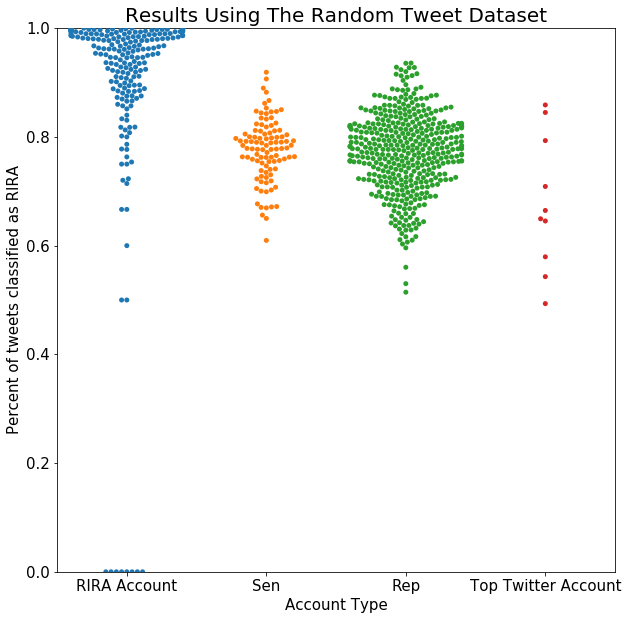

In [532]:
plt.figure(figsize =(10,10))
axes = plt.gca()
axes.set_ylim([0,1])
randplot = sns.swarmplot(x="Position",y="PercentTweetLikeRIRA",data=all_tweets_df_nonzero)
randplot.axes.set_title("Results Using The Random Tweet Dataset",fontsize=20)
randplot.set_ylabel("Percent of tweets classified as RIRA",fontsize=15)
randplot.set_xlabel("Account Type",fontsize=15)
randplot.tick_params(labelsize=15)
#plt.title("Results Using The Random Tweet Dataset")
plt.savefig("RandTweetResults")
plt.show()


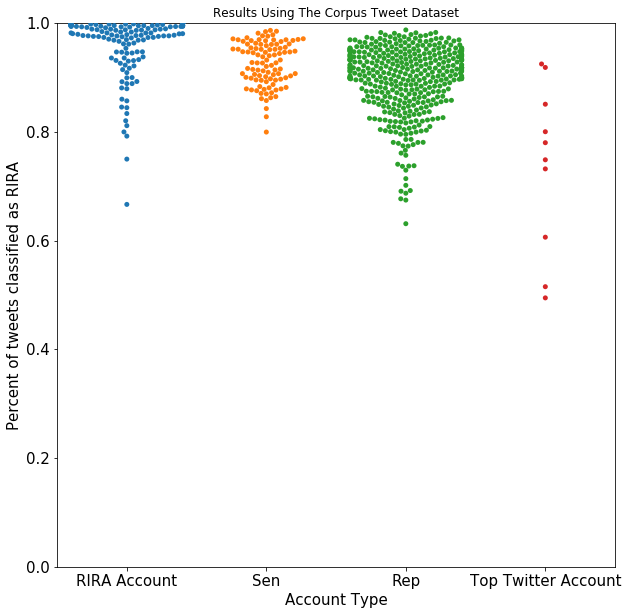

In [536]:
plt.figure(figsize =(10,10))
axes = plt.gca()
axes.set_ylim([0,1])
corpus_plot = sns.swarmplot(x="Position",y="PercentTweetLikeRIRA_corpus",data=all_tweets_df_nonzero)
corpus_plot.set_title("Results Using The Random Tweet Dataset",fontsize=20)
corpus_plot.set_ylabel("Percent of tweets classified as RIRA",fontsize=15)
corpus_plot.set_xlabel("Account Type",fontsize=15)
corpus_plot.tick_params(labelsize=15)
plt.title("Results Using The Corpus Tweet Dataset")
plt.savefig("CorpusTweetResults")
plt.show()


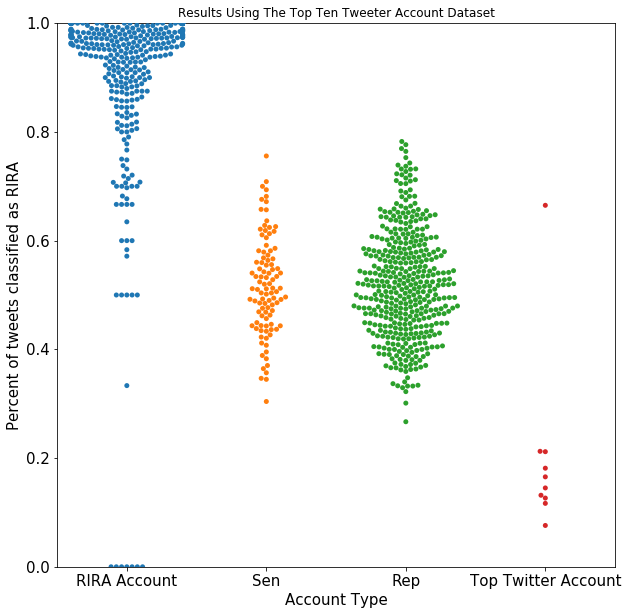

In [535]:
plt.figure(figsize =(10,10))
axes = plt.gca()
axes.set_ylim([0,1])
topten_plot = sns.swarmplot(x="Position",y="PercentTweetLikeRIRA_top10",data=all_tweets_df_nonzero)
topten_plot.axes.set_title("Results Using The Random Tweet Dataset",fontsize=20)
topten_plot.set_ylabel("Percent of tweets classified as RIRA",fontsize=15)
topten_plot.set_xlabel("Account Type",fontsize=15)
topten_plot.tick_params(labelsize=15)
plt.title("Results Using The Top Ten Tweeter Account Dataset")
plt.savefig("TopTenTweetResults")
plt.show()


In [546]:
congress_data_Dem[congress_data_Dem.PercentTweetLikeRIRA==congress_data_Dem.PercentTweetLikeRIRA.min()]

,Wikipedia Names,Position,Joined Congress,ODU-WSDL,CSPAN,TweetCongress,Github,REMARK,PercentTweetLikeRIRA,PartyAffiliation
121,Andy Kim,Rep,3-Jan-19,RepAndyKimNJ,RepAndyKimNJ,RepAndyKimNJ,RepAndyKimNJ,NaN,0.537049,Democratic


In [547]:
congress_data_Dem[congress_data_Dem.PercentTweetLikeRIRA==congress_data_Dem.PercentTweetLikeRIRA.max()]

,Wikipedia Names,Position,Joined Congress,ODU-WSDL,CSPAN,TweetCongress,Github,REMARK,PercentTweetLikeRIRA,PartyAffiliation
362,Lacy Clay,Rep,3-Jan-01,LacyClayMO1,LacyClayMO1,NaN,NaN,(Name is present with no Twitter handle in Git...,0.957843,Democratic


In [548]:
congress_data_GOP[congress_data_GOP.PercentTweetLikeRIRA==congress_data_GOP.PercentTweetLikeRIRA.min()]

,Wikipedia Names,Position,Joined Congress,ODU-WSDL,CSPAN,TweetCongress,Github,REMARK,PercentTweetLikeRIRA,PartyAffiliation
130,Anthony Gonzalez,Rep,3-Jan-19,RepAGonzalez,RepAGonzalez,RepAGonzalez,RepAGonzalez,NaN,0.637053,Republican


In [549]:
congress_data_GOP[congress_data_GOP.PercentTweetLikeRIRA==congress_data_GOP.PercentTweetLikeRIRA.max()]

,Wikipedia Names,Position,Joined Congress,ODU-WSDL,CSPAN,TweetCongress,Github,REMARK,PercentTweetLikeRIRA,PartyAffiliation
488,Steve Scalise,Rep,3-May-08,SteveScalise,SteveScalise,SteveScalise,SteveScalise,NaN,0.959839,Republican


In [551]:
congress_data_GOP[congress_data_GOP.PercentTweetLikeRIRA>0.80].shape

(115, 10)

In [552]:
congress_data_Dem[congress_data_Dem.PercentTweetLikeRIRA>0.80].shape

(183, 10)

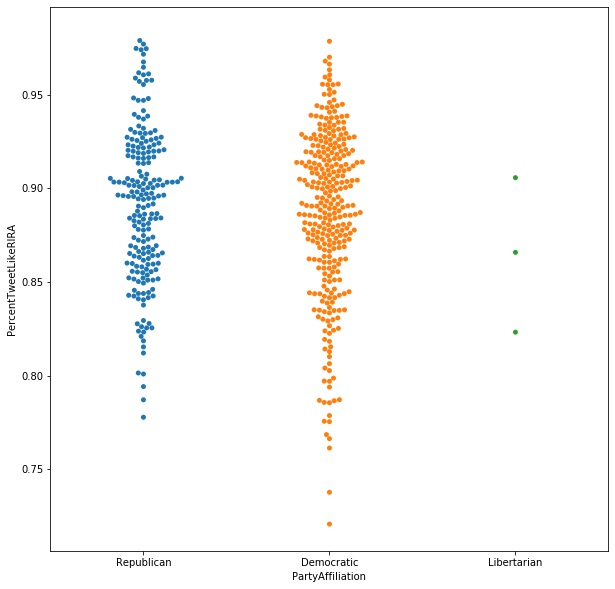

In [620]:
# removing stopwords training = 10,000
plt.figure(figsize =(10,10))
sns.swarmplot(x="PartyAffiliation",y="PercentTweetLikeRIRA",data=congress_data)
plt.show()

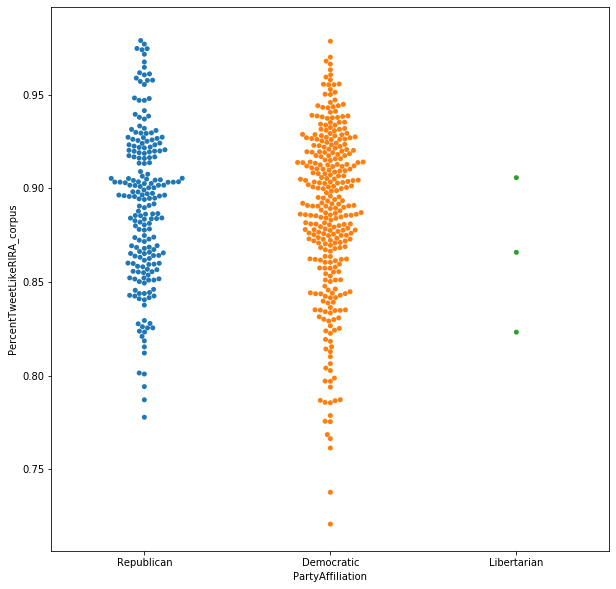

In [676]:
plt.figure(figsize =(10,10))
sns.swarmplot(x="PartyAffiliation",y="PercentTweetLikeRIRA_corpus",data=congress_data)
plt.show()